In [1]:
from __future__ import division, print_function

import time, datetime

import numpy as np

from astropy.modeling import models
from astropy import units as u

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

# Experiment w/ distributions 

$\frac{dn}{dm}= A n^\alpha \rightarrow N = \int^{m_2}_{m_1}{A n^\alpha}= \left. \frac{A}{\alpha+1} n^{\alpha+1} \right\rvert^{m_2}_{m_1} = \frac{A}{\alpha+1} \left(m_2^{\alpha+1} - m_1^{\alpha+1}\right)$

$A$ for normalization: $\int^{m2}_{m1} An^{\alpha}=1 \rightarrow A=\frac{\alpha+1}{m_2^{\alpha+1}-m_1^{\alpha+1}} \rightarrow \frac{\alpha+1}{A} = m_2^{\alpha+1}-m_1^{\alpha+1}$

For CDF from $m_1$ to $x$, need to sample N on [0,1] and then evaluate it as:
$x \; (=m2) = \left(\frac{N (\alpha+1)}{A}+m_1^{\alpha+1} \right)^{\frac{1}{\alpha+1}} = 
 \left[ N \left( m_2^{\alpha+1} - m_1^{\alpha+1} \right) + m_1^{\alpha+1} \right]^{\frac{1}{\alpha+1}}=
 \left[ N m_2^{\alpha+1} + (1-N)m_1^{\alpha+1}   \right]^{\frac{1}{\alpha+1}}$

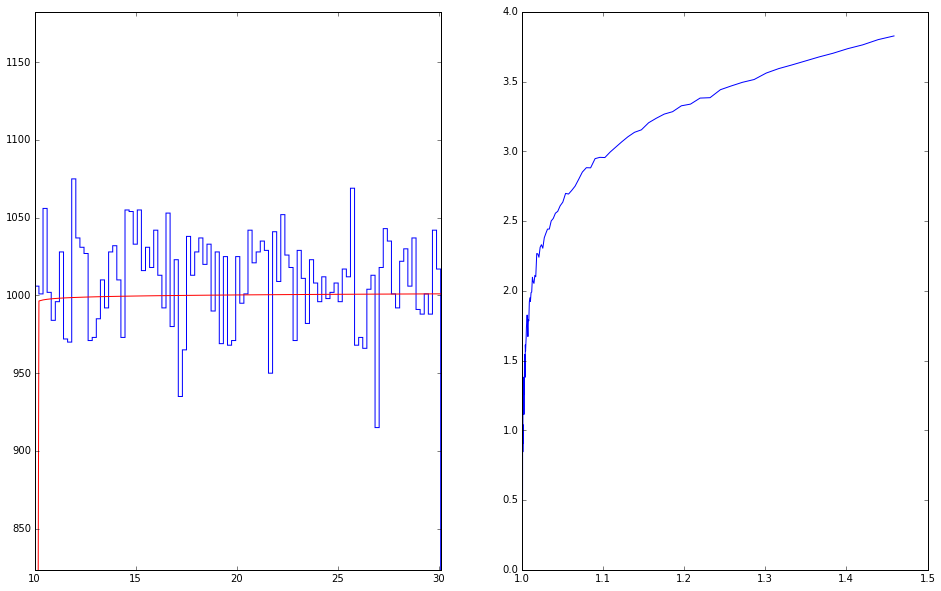

In [3]:
alpha = 0.001
m1, m2 = 10,30.1

nsamp = 100000
samples = np.random.power(alpha+1, nsamp)*(m2-m1)+m1

bins = np.linspace(m1, m2, 100)
lbins = np.logspace(-3, 0, 100)*(m2-m1)+m1

plt.subplot(1, 2, 1)
ninbin = plt.hist(samples, bins=bins,histtype='step')[0]
y = (alpha+1)*((bins-m1)/(m2-m1))**alpha
plt.plot(bins, y*np.mean(ninbin)*np.mean(y), c='r')
plt.xlim(m1, m2)
plt.ylim(np.min(ninbin)*.9, np.max(ninbin)*1.1)

plt.subplot(1, 2, 2)
ninbin = np.histogram(samples, bins=lbins)[0]
plt.plot(np.log10(lbins[:-1]), np.log10(ninbin))

WRONG KIND OF POWER LAW!

## Exponential 

$$\frac{dn}{dm}=A 10^{a (m-\mu)}=A e^{a \ln(10) (m-\mu)}=A e^{\alpha (m-\mu)}$$ wher $\alpha \equiv a \ln(10)$

$$
N= \int^{m_2}_{m_1} A e^{\alpha(m-\mu)} dm = \left. \frac{A}{\alpha} e^{\alpha(m-\mu)} \right\rvert_{m_1}^{m_2}=
\frac{A}{\alpha} e^{-\alpha \mu} \left[ e^{\alpha m_2}-e^{\alpha m_1} \right]
$$

Now we get A for the [$m_1$, $m_2$] range:
$$
N=1 \rightarrow A=\frac{\alpha e^{\alpha \mu}}{e^{\alpha m_2}-e^{\alpha m_1}}
$$

So the final distribution from $m_1$ to $x$ is:
    $$
    N = \frac{e^{\alpha x}-e^{\alpha m_1}}{e^{\alpha m_2}-e^{\alpha m_1}} \rightarrow
    N (e^{\alpha m_2}-e^{\alpha m_1}) + e^{\alpha m_1} = e^{\alpha x} \rightarrow
    x = \frac{1}{\alpha} \ln{\left[ N (e^{\alpha m_2}-e^{\alpha m_1}) + e^{\alpha m_1} \right]}
    $$

In [4]:
def sample_lf(nsamples, alpha, m1, m2):
    N = np.random.rand(nsamples)
    expa1 = np.exp(alpha*m1)
    expa2 = np.exp(alpha*m2)
    return np.log(N*(expa2-expa1)+expa1)/alpha

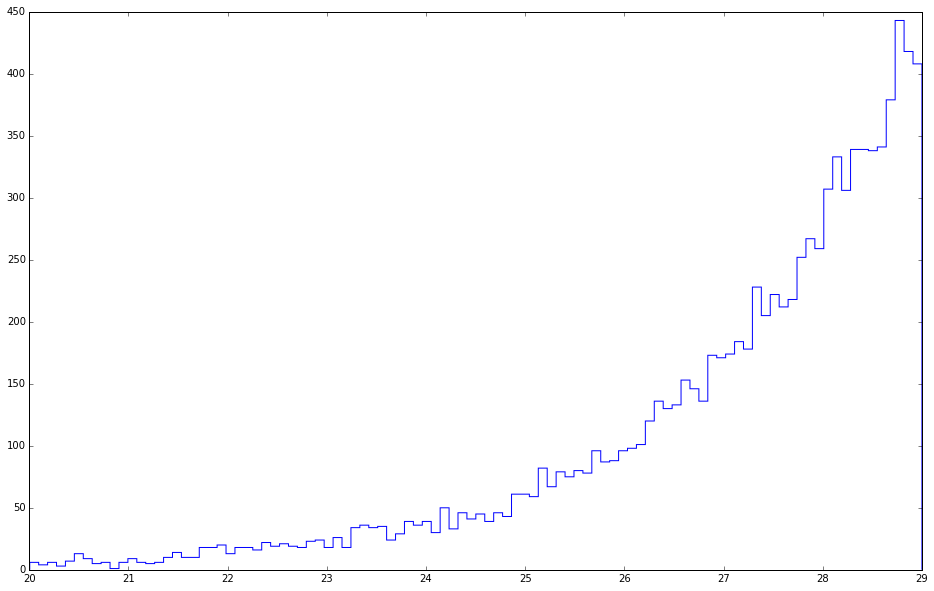

In [5]:
plt.hist(sample_lf(10000, .5, 20, 29), bins=100, histtype='step')
None

# Emceemr tests 

In [6]:
import emceemr
from emceemr import priors
import rgbmcmr

In [7]:
def make_fake_rgb(alpha, beta, mu, brightlimit, faintlimit, nmax, fracrgb):
    """
    
    returns mag0, isrgb
    """    
    #a = alpha + 1
    #b = beta + 1    
    #rgb = np.random.power(a, nmax)*(faintlimit-brightlimit) + brightlimit
    #foreground = np.random.power(b, nmax)*(faintlimit-brightlimit) + brightlimit
    
    rgb = sample_lf(nmax, alpha, brightlimit, faintlimit)
    foreground = sample_lf(nmax, beta, brightlimit, faintlimit)
    
    rgbmsk = rgb>mu
    fgmsk = foreground<mu
    rgb = rgb[rgbmsk]
    foreground = foreground[fgmsk]
    
    starting_fracrgb = len(rgb)/(len(foreground)+len(rgb))
    if starting_fracrgb>fracrgb:
        #too many RGBs
        nrgb = len(foreground)*fracrgb/(1-fracrgb)
        rgb = rgb[:nrgb]
    else:
        #too many fgs
        nfg = len(rgb)*(1-fracrgb)/fracrgb
        foreground = foreground[:nfg]
    
    mags = np.concatenate((rgb, foreground))
    isrgb = np.zeros(len(mags), dtype=bool)
    isrgb[:len(rgb)] = True
    
    unsorti = np.random.permutation(len(mags))
    mags = mags[unsorti]
    isrgb = isrgb[unsorti]
    
    return mags, isrgb

In [8]:
#median absolute deviation from ASTs
madmodel = models.Legendre1D(20, c0=-3954355396.3633738, c1=1353694208.4087687, c2=-124848799.79526304, c3=4897226.378521032, c4=-57041.00249220571, c5=-1549.1100474853888, c6=30.190195895799725, c7=1.1368681316643618, c8=-0.03563103282644921, c9=6.0712498989515646e-05, c10=4.892644246415783e-06, c11=8.248737934921185e-08, c12=-2.3350690477921424e-09, c13=-1.8352224226398223e-11, c14=5.350673251357965e-13, c15=2.4468515243894513e-15, c16=2.6121935517894807e-17, c17=-4.622081469223215e-18, c18=8.23871918441632e-20, c19=-6.005849952016176e-22, c20=1.6539943309668438e-24)

a= 0.690775527898


/home/erik/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(327, 56, 0.85378590078328986)

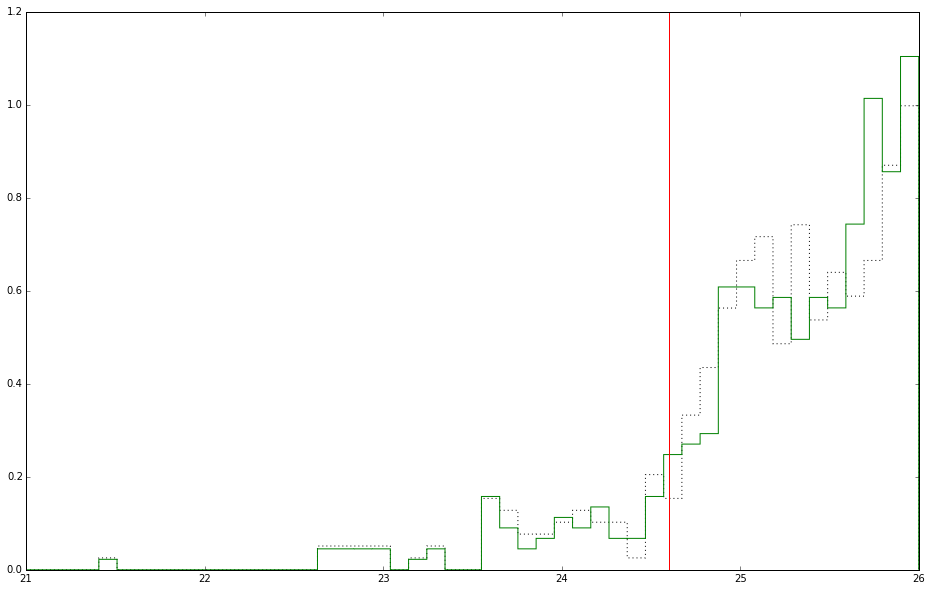

In [9]:
a = np.log(10)*.3
print('a=',a)
b = 1
mu = 24.6

realmags, isrgb = make_fake_rgb(a, b, mu, 21, 29, 5000, .986)

asterrs = madmodel(realmags)*1.483
asterrmags = realmags+np.random.randn(len(realmags))*asterrs


bins = np.linspace(21,26,50)
plt.hist(realmags, bins=bins,histtype='step',normed=True, ls='dotted', color='k')
plt.hist(asterrmags, bins=bins,histtype='step',normed=True, color='g')

inwindow = (bins[0]<realmags)&(realmags<bins[-1])
inrgbwindow = inwindow&(realmags>mu)
inotherwindow = inwindow&(realmags<mu)

plt.axvline(mu,color='r')
np.sum(inrgbwindow), np.sum(inotherwindow), np.sum(inrgbwindow)/np.sum(inwindow)

## Now do test runs of the MCMC

In [10]:
pris = dict(tipmag=priors.UniformPrior(23, 25.5),
            alphargb=priors.UniformPrior(0, 5), 
            alphaother=priors.UniformPrior(0, 5),
            fracother=priors.UniformPrior(0,0.5))

### "Intrinsic" mags 

In [11]:
astmod = rgbmcmr.RGBModel(realmags[inwindow], None, priors=pris)

In [12]:
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(5000, burnin=1000)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-11-22 13:32:10.342449
Took 0.0883653362592 min


Acors:
tipmag: 94.4912497518
alphargb: 87.7206834739
alphaother: 80.1992524406
fracother: 73.4757094275
Acceptance Fractions:
[ 0.4172,  0.398 ,  0.4068,  0.4208,  0.3282,  0.4318,  0.42  ,  0.4112,
  0.4146,  0.4186,  0.4162,  0.3962,  0.4194,  0.4086,  0.3012,  0.4124]


/home/erik/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


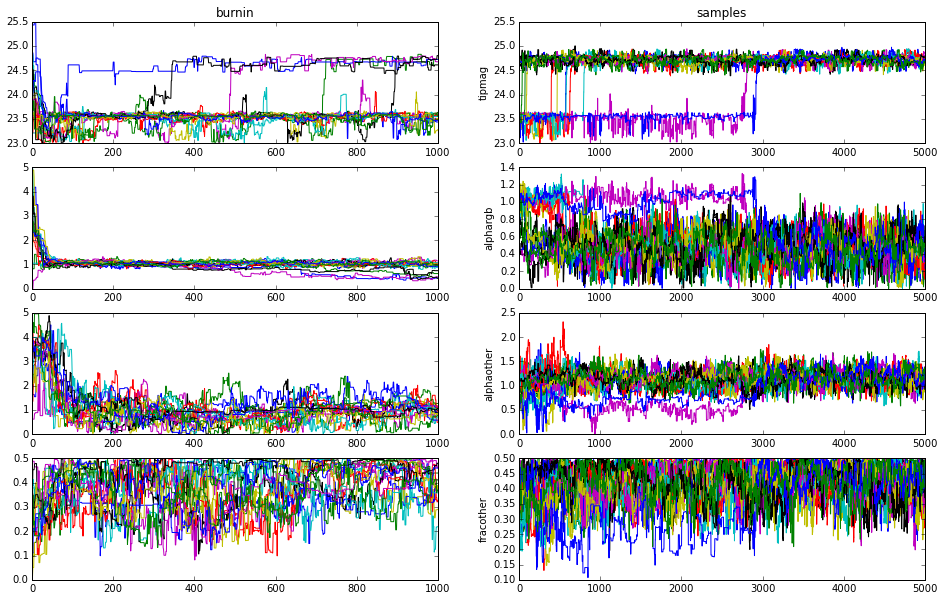

/home/erik/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


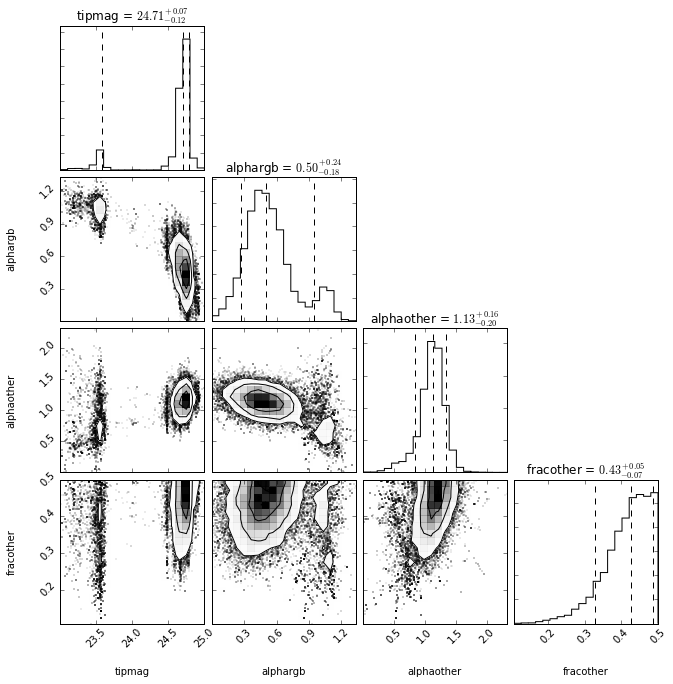

In [13]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

### With AST 

In [14]:
astmod = rgbmcmr.RGBModel(asterrmags[inwindow], madmodel(asterrmags[inwindow])*1.483, priors=pris)

In [15]:
#experimental timing run
st = time.time()
sampler = astmod.initialize_and_sample(15, burnin=5)
et = time.time()
dt = (et - st)*u.second
    
ntarg = 6000
print('20 samples took', dt, 'which scales up to',ntarg,'samples in',(dt*ntarg/20).to(u.minute))

20 samples took 0.136371850967 s which scales up to 6000 samples in 0.681859254837 min


In [16]:
#now the real deal
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(5000, burnin=1000)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-11-22 13:32:19.477003
Took 0.566248766581 min


Acors:
tipmag: 47.5174298546
alphargb: 53.6235022377
alphaother: 38.9567696455
fracother: 46.4008694196
Acceptance Fractions:
[ 0.497 ,  0.5316,  0.5336,  0.5388,  0.5288,  0.5296,  0.5316,  0.5274,
  0.5312,  0.522 ,  0.5206,  0.5168,  0.5136,  0.5098,  0.5032,  0.512 ]


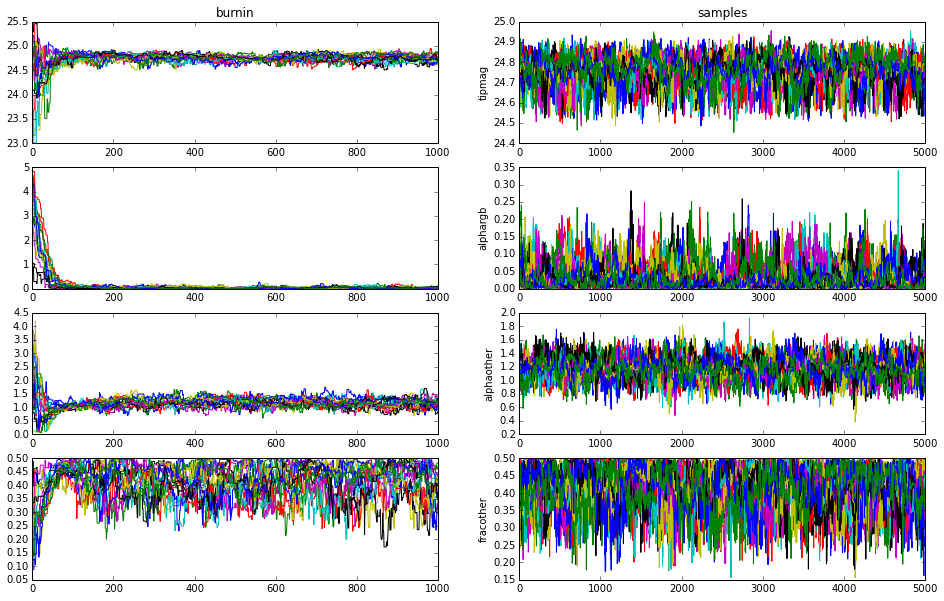

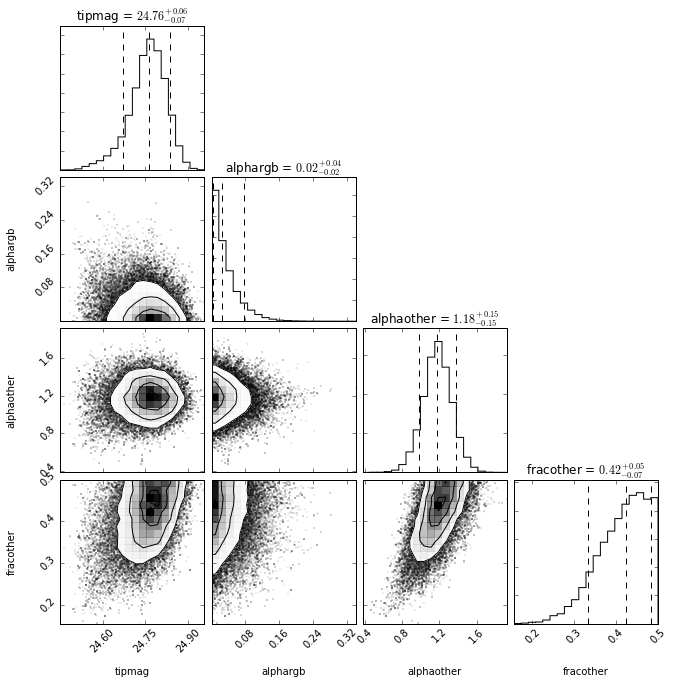

In [17]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

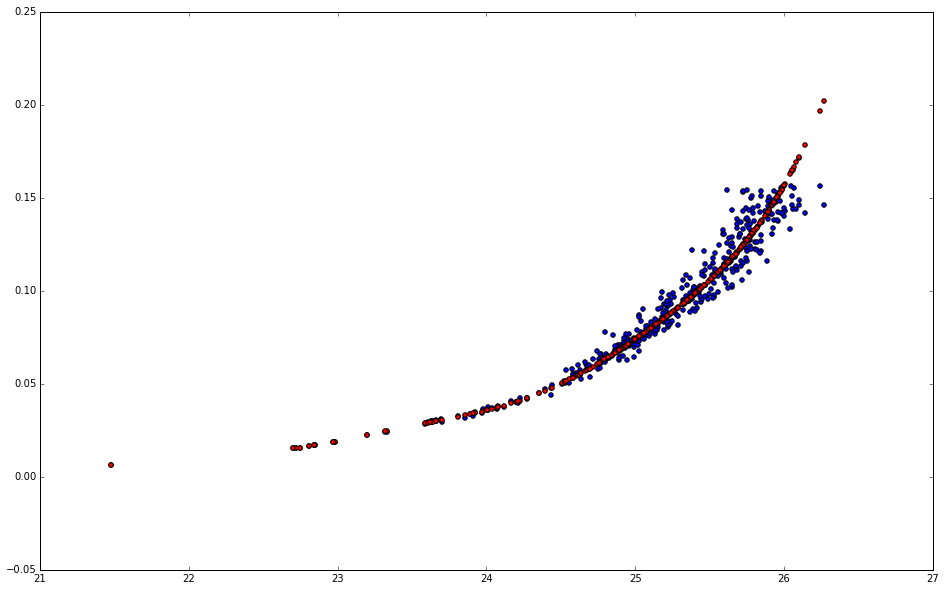

In [18]:
plt.scatter(asterrmags[inwindow], asterrs[inwindow])
plt.scatter(asterrmags[inwindow], madmodel(asterrmags[inwindow])*1.483,c='r')

# Test with the completeness function model 

In [19]:
reload(rgbmcmr)

astmod = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          funcmags=np.linspace(21, 29,100), 
                          uncfunc=lambda x:madmodel(x)*1.483,
                          priors=pris)

In [20]:
#experimental timing run
st = time.time()
sampler = astmod.initialize_and_sample(15, burnin=5)
et = time.time()
dt = (et - st)*u.second
    
ntarg = 6000
print('20 samples took', dt, 'which scales up to',ntarg,'samples in',(dt*ntarg/20).to(u.minute))

20 samples took 0.980599880219 s which scales up to 6000 samples in 4.90299940109 min


In [21]:
#now the real deal
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(5000, burnin=1000)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-11-22 13:32:57.782488
Took 4.48495978117 min


Acors:
tipmag: 83.1438428212
alphargb: 66.079353274
alphaother: 92.7437429985
fracother: 65.3316124183
Acceptance Fractions:
[ 0.3918,  0.3928,  0.3768,  0.357 ,  0.414 ,  0.4066,  0.3454,  0.4078,
  0.454 ,  0.4376,  0.3952,  0.4264,  0.4318,  0.4088,  0.4662,  0.4604]


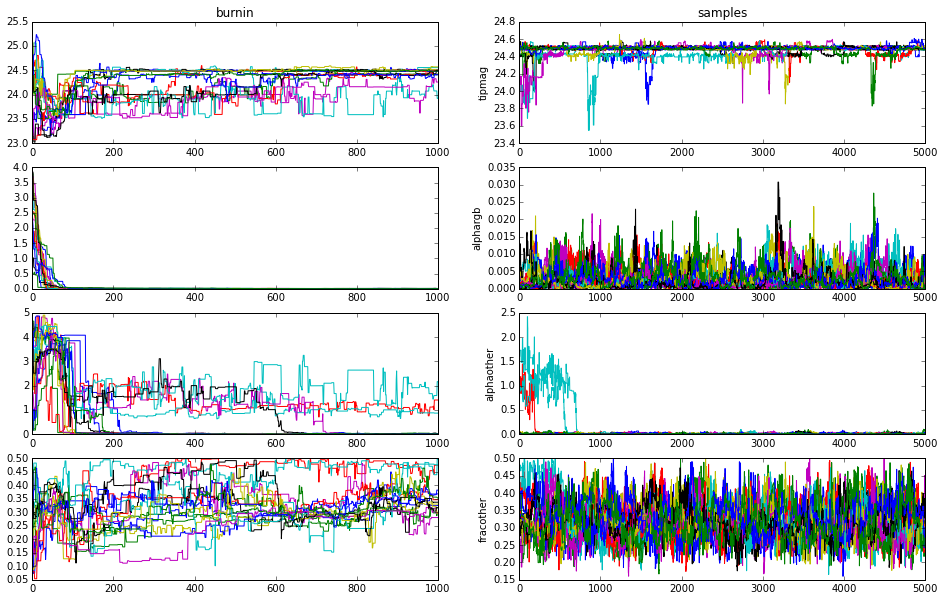

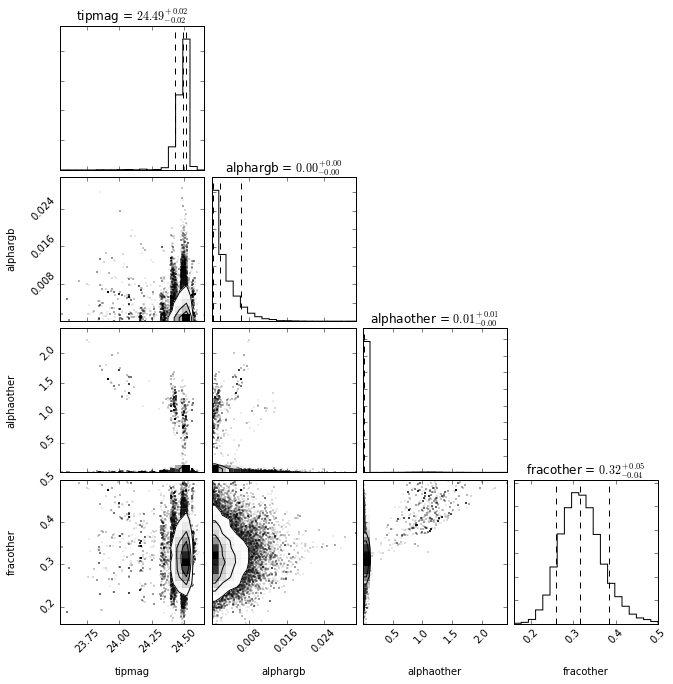

In [22]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

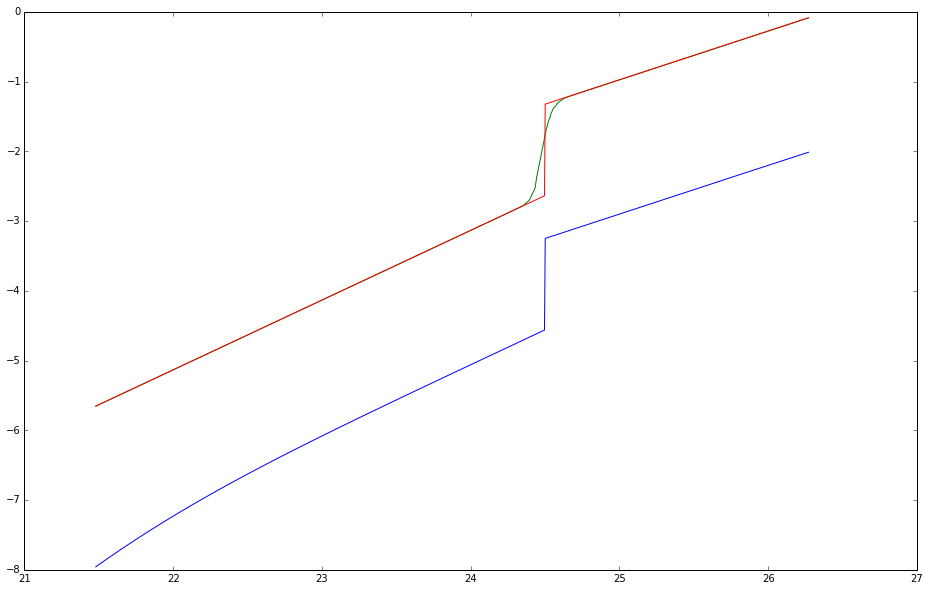

In [23]:
reload(rgbmcmr)

astmod1 = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          funcmags=np.linspace(21, 29,100), 
                          #uncfunc=lambda x:madmodel(x)*1.483*1,
                           uncfunc=lambda x:1,
                          priors=pris)
astmod1.plot_lnprob(24.5,0.7,1,.27, 1000)

astmod2 = rgbmcmr.RGBModel(asterrmags[inwindow], asterrs[inwindow],
                          priors=pris)
astmod2.plot_lnprob(24.5,0.7,1,.27, astmod2.magdata)

astmod3 = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          priors=pris)
astmod3.plot_lnprob(24.5,0.7,1,.27, 1000)
None

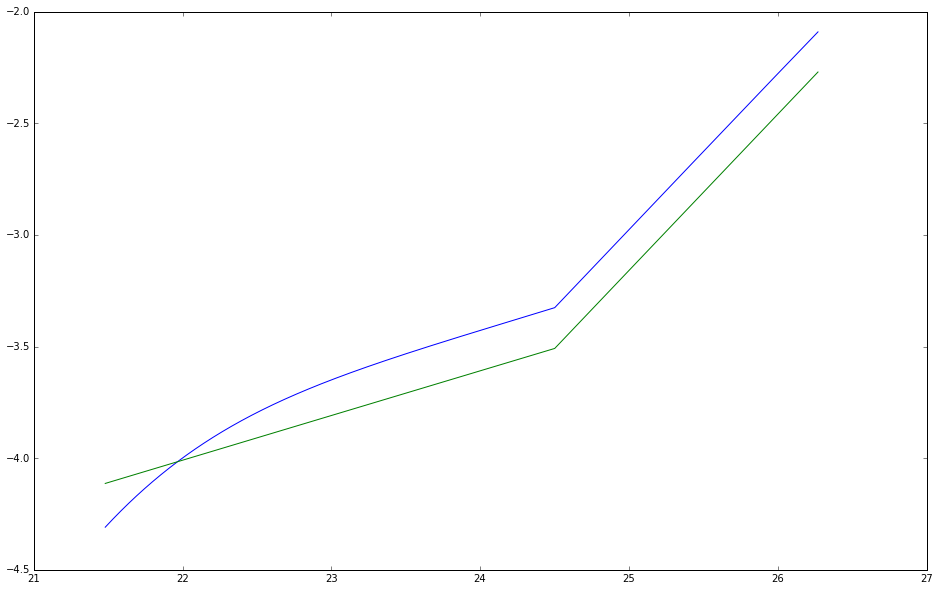

In [24]:

astmod1 = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          funcmags=np.linspace(21, 29,100), 
                          #uncfunc=lambda x:madmodel(x)*1.483*1,
                           uncfunc=lambda x:1,
                          priors=pris)
astmod1.plot_lnprob(24.5,0.7,0.2,1, 1000)

astmod1 = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          funcmags=np.linspace(21, 29,100), 
                          #uncfunc=lambda x:madmodel(x)*1.483*1,
                           uncfunc=lambda x:0.1,
                          priors=pris)
astmod1.plot_lnprob(24.5,0.7,0.2,1, 1000)
None

# Numerical derivative tests 

In [4]:
from scipy.stats import norm
from scipy.special import erf

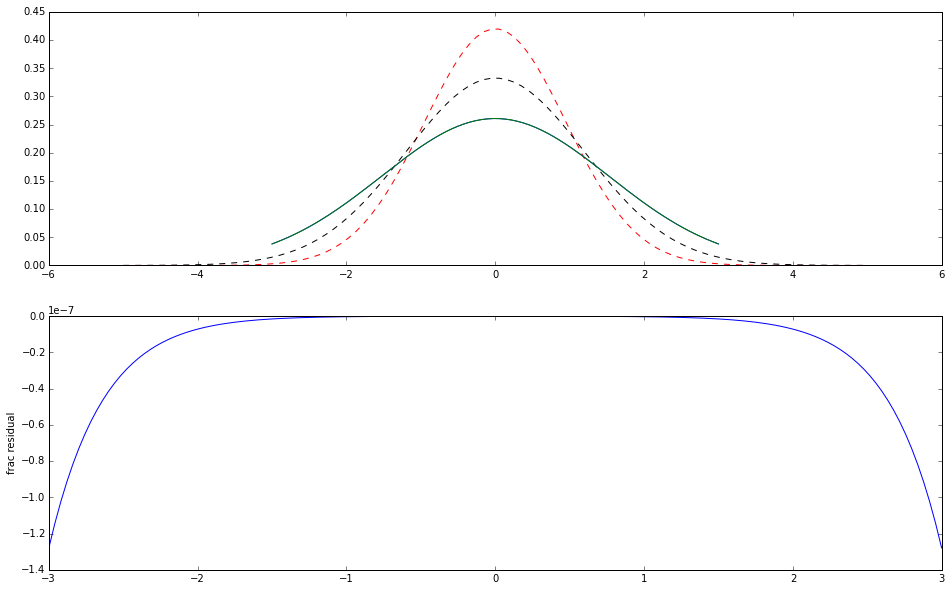

In [61]:
#two gaussians convolved
s1 = 0.95
s2 = 1.2
s12 = np.hypot(s1, s2)

norm1 = norm(scale=s1)
norm2 = norm(scale=s2)
norm12 = norm(scale=s12)

x = np.linspace(-5,5, 100) # integrate over this
y = np.linspace(-3,3, 150) # the independent variable
xr = x.reshape(x.size, 1)
yr = y.reshape(1, y.size)
res = np.trapz(norm1.pdf(xr)*norm2.pdf(xr-yr), x, axis=0)

plt.subplot(2,1,1)
plt.plot(x, norm1.pdf(x), '--r')
plt.plot(x, norm2.pdf(x), '--k')
plt.plot(y, res, c='b')
plt.plot(y, norm12.pdf(y), c='g')

plt.subplot(2,1,2)
true = norm12.pdf(y)
plt.plot(y, (res-true)/true)
plt.ylabel('frac residual')
None

(array([ 1.0014005]), array([ 0.99150917]))

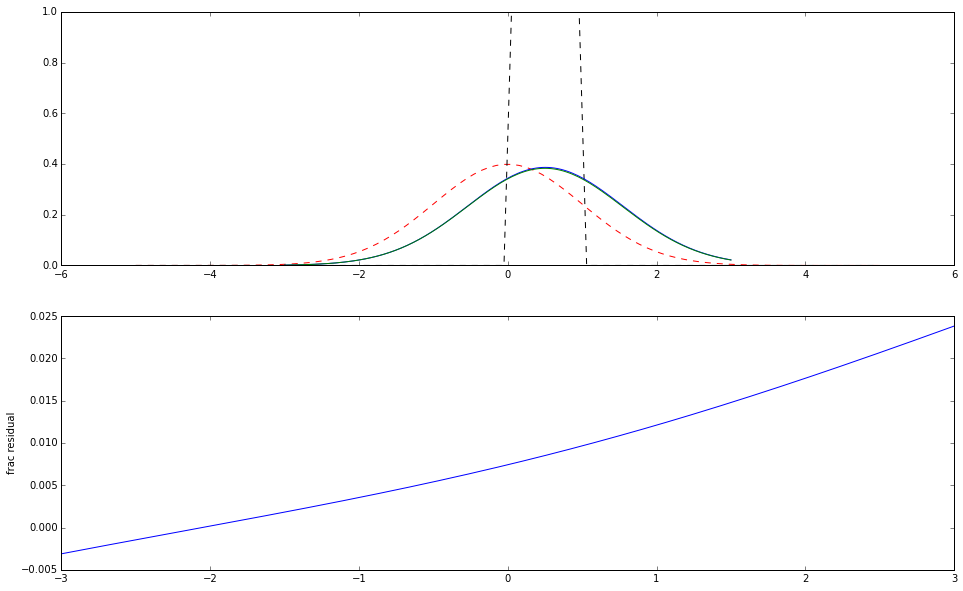

In [139]:
#square theta
s = 1
norms = norm(scale=s)

x = np.linspace(-5,5, 100) # integrate over this
y = np.linspace(-3,3, 150) # the independent variable
xr = x.reshape(x.size, 1)
yr = y.reshape(1, y.size)

theta = np.ones_like(xr)
theta[xr>1] = 0
theta[xr<0] = 0

res = np.trapz(norms.pdf(xr-yr)*theta, xr, axis=0)
true = (erf(2**-0.5 * y/s) - erf(2**-0.5 * (y-1)/s)) * 2**-1 / s 

plt.subplot(2,1,1)
plt.plot(x, norms.pdf(x), '--r')
plt.plot(x, theta.ravel(), '--k')
plt.plot(y, res, c='b')
plt.plot(y, true, c='g')

plt.subplot(2,1,2)
plt.plot(y, (res-true)/true)
plt.ylabel('frac residual')
np.trapz(res, yr), np.trapz(true, yr)